# Hyper Parameter Optimization of Clustering Algorithms
Written by Dr. Hanan Shteingart, All rights reserved
## Q. How do you know how to set parameters such as linkage, metrics etc for an unsupervised clustering algorithms? 
## A. You can estimate clustering quality using intrinsic metrics such as silhouette score!

# Get some DATA!
As usual, we will use the Iris dataset as an example...
![Iris](http://dataaspirant.com/wp-content/uploads/2017/01/irises.png)

## Basic Imports

In [1]:
import numpy as np # impoty numpy
import pandas as pd # import pandas package, this is for describing a dataset etc.
#this is just for making plot inline in the notebook:
%matplotlib inline
import matplotlib.pyplot as plt

## Load the Data

In [2]:
from sklearn import datasets # import datasets package
iris = datasets.load_iris() # get iris data into iris variable

## Parse the Data

In [30]:
# define a feature matrix
feature_matrix = iris['data'] # get the feature matrix
# define the labels. NOTE: we will regard these as unknowns!
labels = iris['target'] # get the label
n_labels = len(np.unique(labels)) # how many unique labels?
n_clusters = n_labels # set the clustering number to the correct one
# describe the data
print(iris['DESCR'])
print(pd.DataFrame(feature_matrix).describe())



Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================

    :Missing Attribute Values: None
  

## Normalize the data

In [4]:
from sklearn.preprocessing import scale
feature_matrix = scale(feature_matrix, axis=0)

# Build a simple clustering model
[Quick refresher on How Agglomerative Clustering works](https://youtu.be/XJ3194AmH40?t=269)

In [5]:
from sklearn.cluster.hierarchical import AgglomerativeClustering # import the Agglomerative Clustering algorithm

In [6]:
model = AgglomerativeClustering(linkage = "ward", n_clusters=n_clusters, affinity='euclidean') # initiate the model
y_hat=model.fit_predict(feature_matrix) # fit the model

# How well did we do?
## If we know the true underlying labels, it's easy! Use Supervised Metrics, e.g. V-Score

A well know metric is the **v-score** metric scroe. 
* This score is identical to normalized mutual information score.
* The V-measure is the harmonic mean between *homogeneity* and *completeness*:

$v = \dfrac{2 \times(homogeneity \times completeness}{homogeneity + completeness}$

* Homogeneity - Clusters contain only data points which are members of a single class.
* Completness - Data points that are members of a given class are elements of the same cluster.

In [15]:
from sklearn.metrics import v_measure_score
# Homogenity: each cluster contains only members of a single class
print('v_measure_score = %s' % v_measure_score(labels_true=labels, labels_pred=y_hat))
print('v_measure_score with perfect clusters = %s' % v_measure_score(labels_true=labels, labels_pred=labels))

v_measure_score = 0.560637716465
v_measure_score with perfect clusters = 1.0


## What if we don't know the real labels?... more realistic scenario

We can use [Silhouette coefficients][1]. 

* It's a number between -1 and 1. 
* ~1 - sample is far away from the neighboring clusters. [GOOD]
* ~0 - the sample is on or very close to the decision boundary between two neighboring clusters [BAD]
* ~-1 - the sample might have been assigned to the wrong cluster. [UGLY]

Formally:

* Assume the data have been clustered via any technique, such as k-means, into $k$ clusters. 
* For each datum $i$, let $a(i)$ be the **average dissimilarity** of $i$ with all other data within the same cluster. We can interpre $a(i)$ as how well $i$ is assigned to its cluster (the smaller the value, the better the assignment). 
* We then define the average dissimilarity of point $i$ to a cluster $c$ as the average of the distance from $i$ to all points in $c$.
* Let $b(i)$ be the lowest average dissimilarity of $i$ to any other cluster, of which $i$ is **NOT** a member. The cluster with this lowest average dissimilarity is said to be the **"neighbouring cluster"** of $i$ because it is the next best fit cluster for point $i$. 
* We now define a silhouette: $s(i) = \frac{b(i) - a(i)}{\max\{a(i),b(i)\}}$

[1]: https://en.wikipedia.org/wiki/Silhouette_(clustering)

In [8]:
from sklearn.metrics import silhouette_score
print('score = %s' % silhouette_score(feature_matrix, y_hat, metric='euclidean'))
print('perfect score = %s' % silhouette_score(feature_matrix, labels, metric='euclidean'))

score = 0.445539563992
perfect score = 0.379753292616


In [9]:
# Helper function to compute both scores and print it

In [10]:
# calc performance
def calc_metric(x, labels_true, labels_pred):
    return {'v_measure_score': v_measure_score(labels_true, labels_pred), 
            'silhoette': silhouette_score(x, labels_pred, metric='euclidean')}
def print_dict(d):
    for k, v in d.items():
        print('%s = %s' % (k,v))

In [11]:
print('true labels:')
print('============')
print_dict(calc_metric(feature_matrix, labels, labels))
print('predicted labels:')
print('=================')
print_dict(calc_metric(feature_matrix, labels, y_hat))

true labels:
v_measure_score = 1.0
silhoette = 0.379753292616
predicted labels:
v_measure_score = 0.675470185344
silhoette = 0.445539563992


# How does intrinsic metric change when data is shuffled?

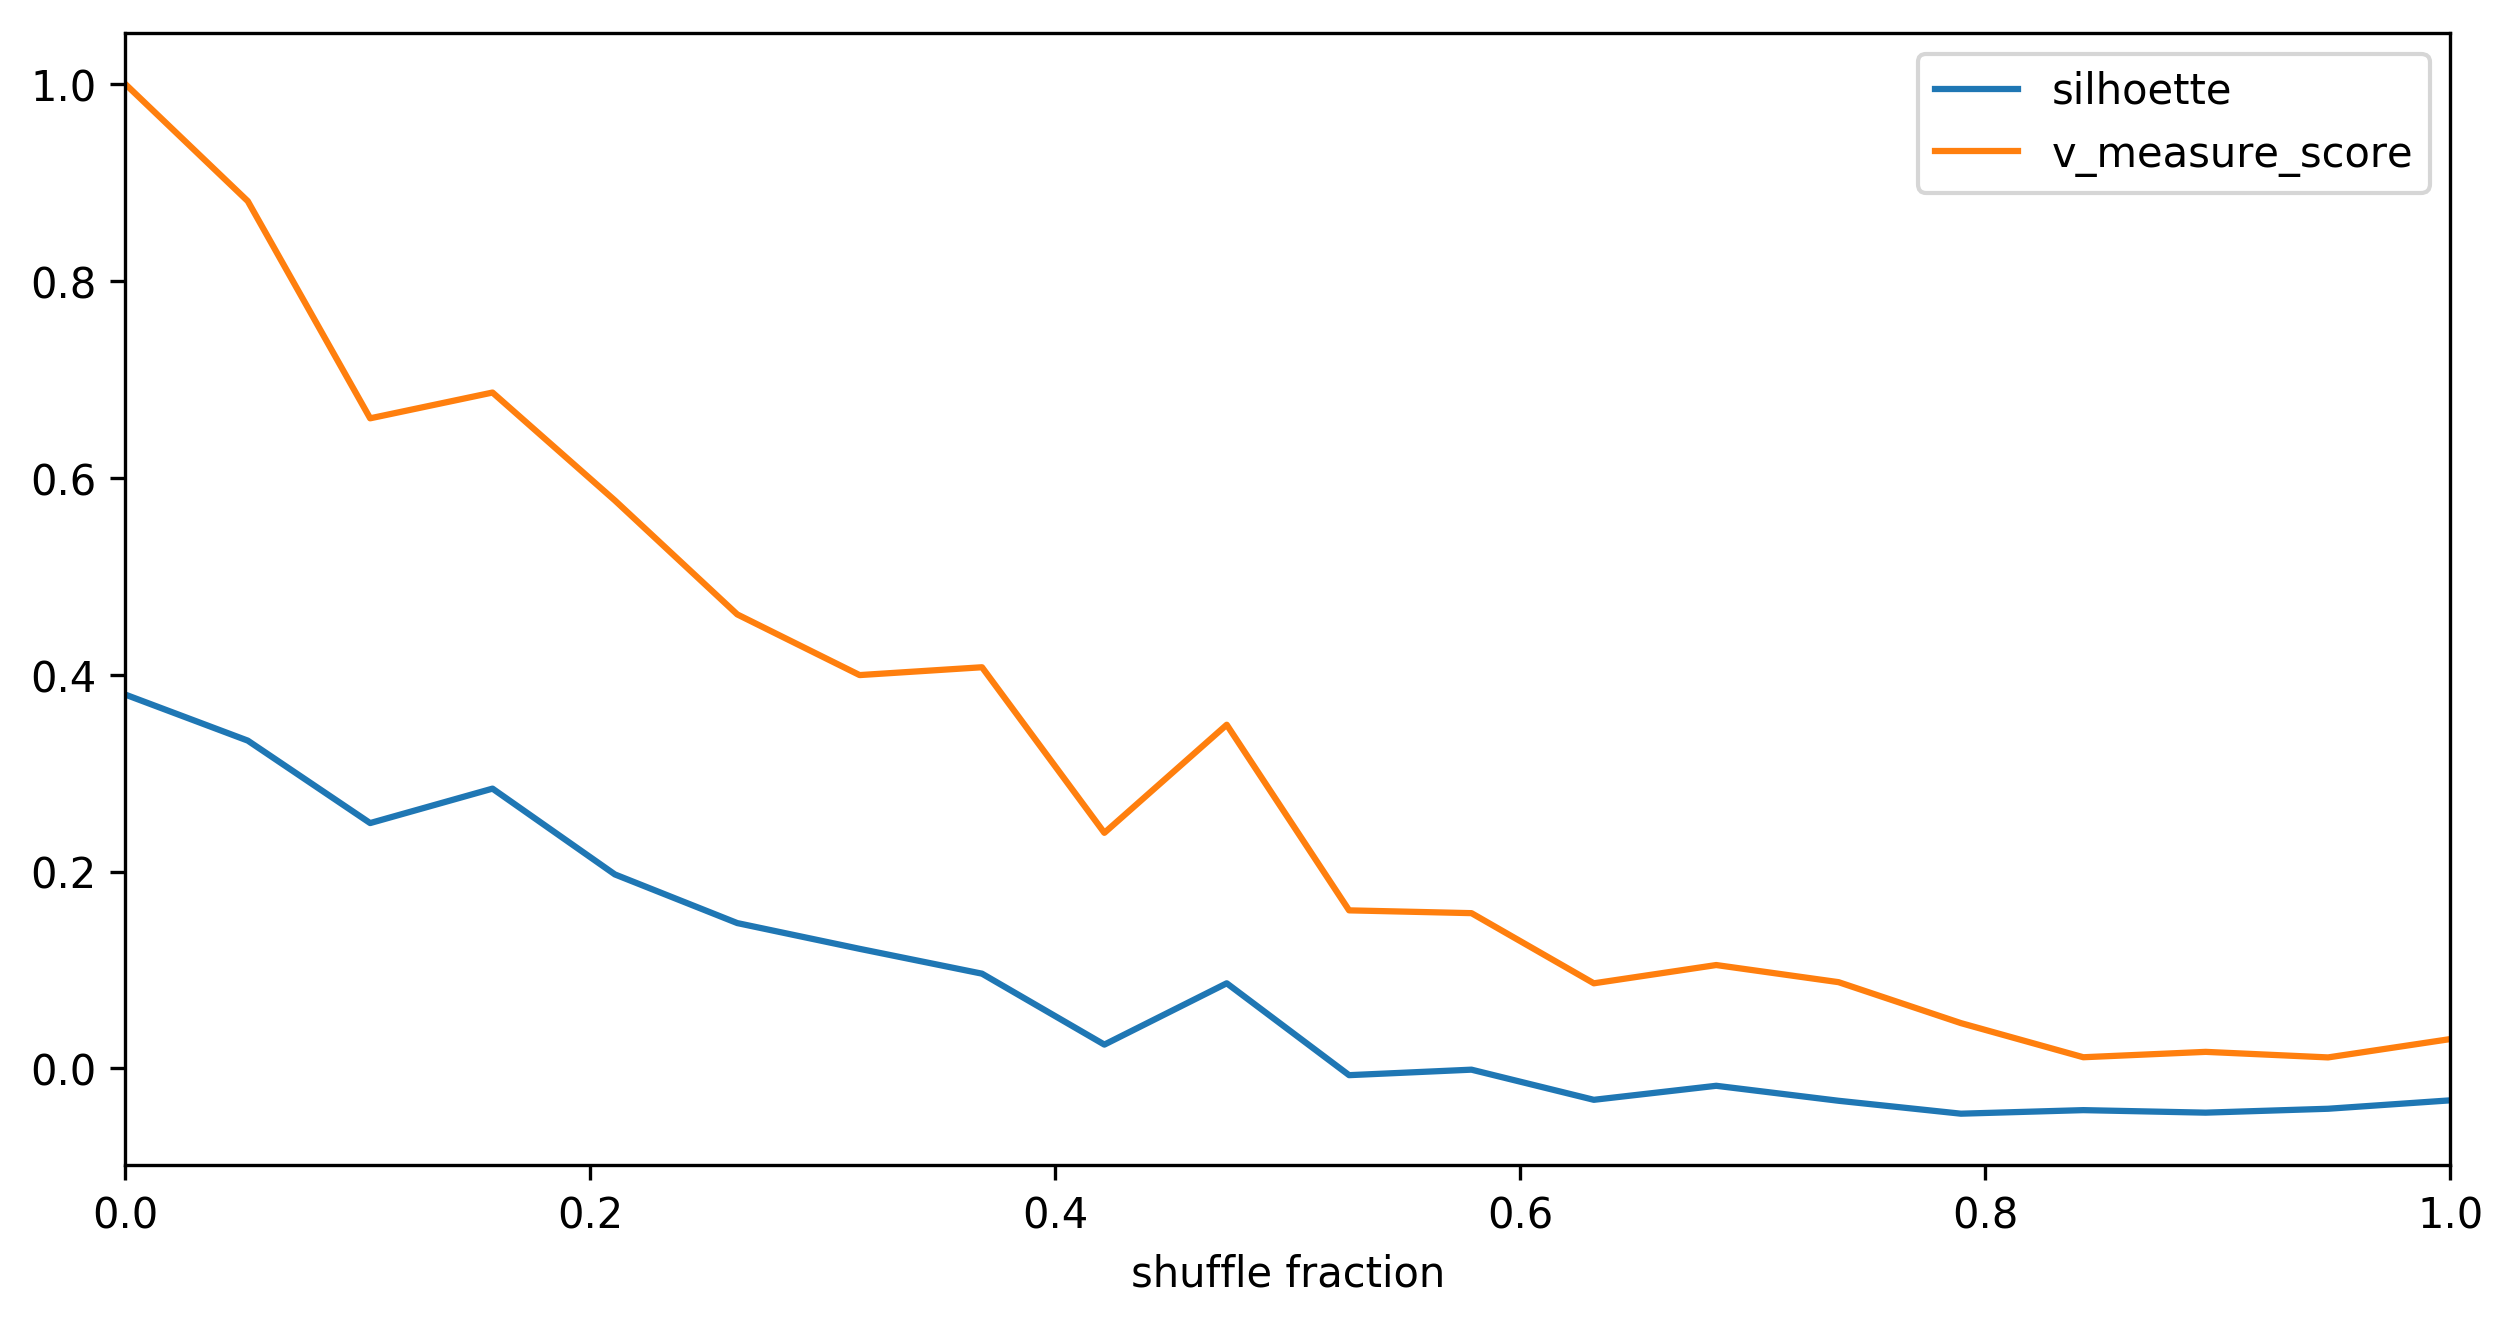

In [12]:
from sklearn.utils import shuffle

shuffle_size_list = np.linspace(0,1,20) # define a shuffle size range
metric = [] # an empty list to contain the results
n = len(labels) # data set size
index = np.arange(n) # index 0:n-1 in an array to be used for shuffeling
for shuffle_size in shuffle_size_list: # for every shuffle size
    size = int(np.round(shuffle_size * n))
    shuffle_indices = np.random.choice(index, size=size ,replace=False)
    y_hat = labels.copy() # copy by value to protect original array
    y_hat[shuffle_indices] = shuffle(y_hat[shuffle_indices]) # create a shuffled version
    metric.append(calc_metric(feature_matrix, labels, y_hat)) # keep the result

# convert to a pandas's DataFrame
metric_df = pd.DataFrame(metric)
# plot
metric_df.index = shuffle_size_list
metric_df.index.name = 'shuffle fraction'
plt.figure(figsize=(10,5), dpi=300)
metric_df.plot(legend=True, ax = plt.gca());

# Interim Conclusion 
Intrinsic measurement such as silhouette can be a proxy for clustering performance even if we do **NOT** know the true underlying true labels

# Hyper Parameter Clustering Optimization Using Intrinsic Metric
So, if we can measure performance, we can optimize meta-parameters of the clustering. 
Let's take as an example the problem of decising on the linkage method.

Reminder:
![type of linkages](https://i.ytimg.com/vi/vg1w5ZUF5lA/maxresdefault.jpg)
[source of image](https://i.ytimg.com/vi/vg1w5ZUF5lA/maxresdefault.jpg)

# Loop around parameters and decide which is best

ground truth:
v_measure_score = 1.0
silhoette = 0.379753292616


/home/hanan/anaconda3/lib/python3.6/site-packages/pandas/tools/plotting.py:2470: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


,silhoette,v_measure_score
ward,0.445540,0.675470
complete,0.448791,0.653048
average,0.479451,0.713099


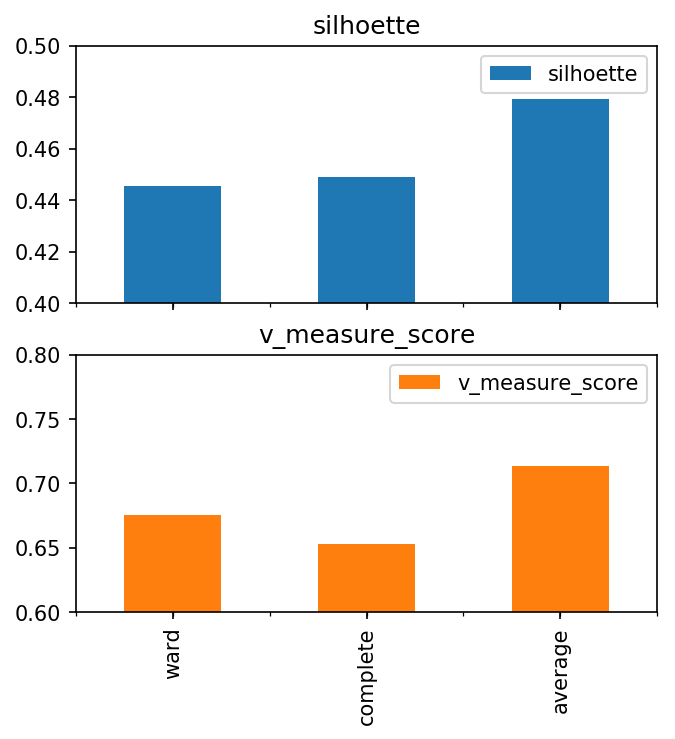

In [13]:
LINKAGES = ["ward", "complete", "average"]
print('ground truth:')
print_dict(calc_metric(feature_matrix, labels, labels))
metric = []
for linkage in LINKAGES:
    model = AgglomerativeClustering(linkage =linkage, n_clusters=n_clusters, affinity='euclidean')
    y_hat = model.fit_predict(feature_matrix)
    metric.append(calc_metric(feature_matrix, labels, y_hat))
df = pd.DataFrame(metric, index=LINKAGES)
plt.figure(figsize=(5,5), dpi=150)
ax1, ax2 = df.plot(kind='bar', subplots=True,ax = plt.gca(), sharex=True)
ax1.set_ylim(0.4,0.5)
ax2.set_ylim(0.6, 0.8)
df
# life is tough. Sometimes it doen't work

/home/hanan/anaconda3/lib/python3.6/site-packages/pandas/tools/plotting.py:2470: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


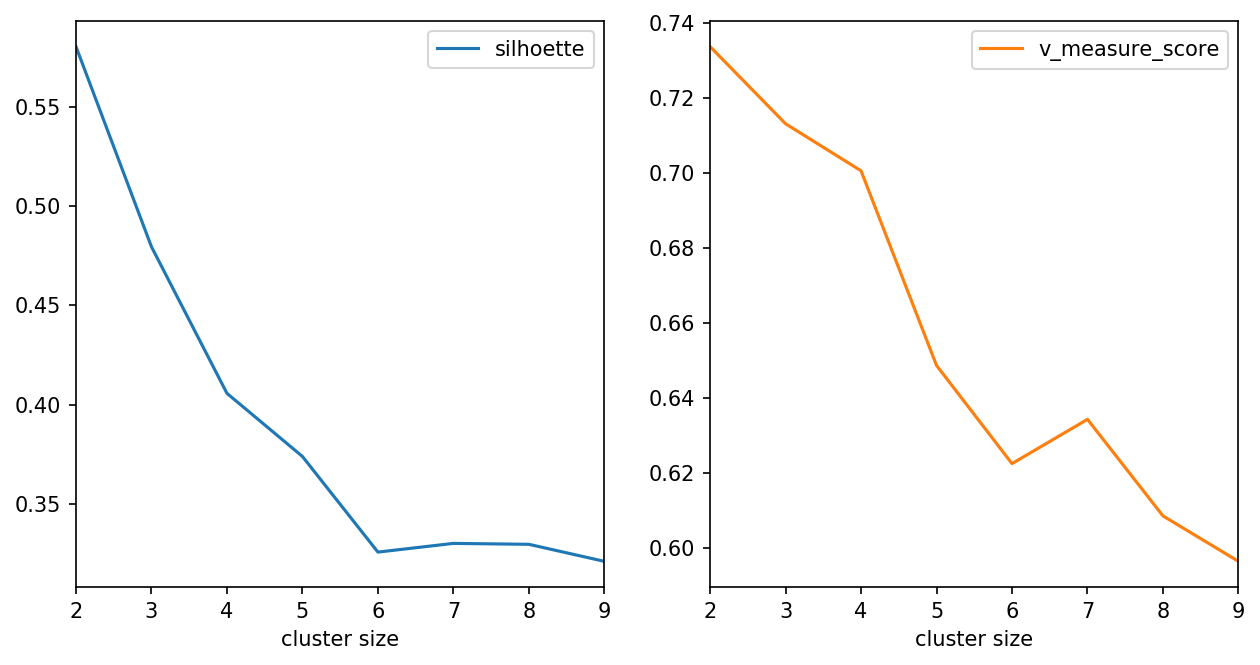

In [26]:
CLUSTER_SIZE = np.arange(2,10)
metric = []
for n_clusters in CLUSTER_SIZE:
    model = AgglomerativeClustering(linkage ='average', n_clusters=n_clusters)
    y_hat = model.fit_predict(feature_matrix)
    current_metric = calc_metric(feature_matrix, labels, y_hat)
    metric.append(current_metric)

df = pd.DataFrame(metric, index=CLUSTER_SIZE)
fig = plt.figure(figsize=(10,5), dpi = 150)
ax = df.plot(subplots=True, layout=(1,2), ax=plt.gca());
[a.set_xlabel('cluster size') for a in ax.ravel()]
#[a.set_ylim(0,1)for a in ax.ravel()]


# Conclusion
* We learned about extrinsic (supervised) and intrisinc (unsupervised) clustering metrics.
* We showed how silohette score can help in optimizing for hyper-parameter optimization in clustering problems.
* We showed that for selecting the number of clusters, the method failed. There are other methods such as in the refernecs below which are more accureate (e.g. elbow method for explained variance, gap-statistics etc.). 
* Note that in a [toy examples](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py) it actually works very well...
* In R there is a special package ([fviz_nbclust](https://rdrr.io/cran/factoextra/)) for comparing 40 (!!!) different methods of # of clusters. Here is what it gets for the Iris example above:
![](http://www.sthda.com/sthda/RDoc/figure/clustering/determining-the-number-of-clusters-nbclust-ggplot2-1.png)

# References

1. [Sklearn Clustering Metrics](http://scikit-learn.org/stable/modules/classes.html#clustering-metrics)
1. [Determining the optimal number of clusters: 3 must known methods - Unsupervised Machine Learning](http://www.sthda.com/english/wiki/determining-the-optimal-number-of-clusters-3-must-known-methods-unsupervised-machine-learning)
2. [Choosing the right linkage method for hierarchical clustering](https://stats.stackexchange.com/questions/195446/choosing-the-right-linkage-method-for-hierarchical-clustering)
3. [How to select a clustering method? How to validate a cluster solution (to warrant the method choice)?](https://stats.stackexchange.com/questions/195456/how-to-select-a-clustering-method-how-to-validate-a-cluster-solution-to-warran/195481#195481)
4. [Calinski-Harabaz Index](http://scikit-learn.org/stable/modules/clustering.html#calinski-harabaz-index)
5. [Sillohette][1]

[1]: https://en.wikipedia.org/wiki/Silhouette_(clustering)